In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import common

In [2]:
finn_dir = Path("../data_out/langmuir/default_finn")

In [3]:
config = json.loads((finn_dir / "input.json").read_text())
config

{'y_train_path': 'data/FINN_forward_solver/retardation_langmuir/c_train.npy',
 'output_dir': 'data_out/langmuir/default_finn',
 'train_split_idx': 51,
 'max_epochs': 100,
 'seed': 87364854,
 'c_field_seed': None,
 'dropout': 0}

In [4]:
analytical_retardation_type = Path(config["output_dir"]).parts[1]
analytical_retardation_type

'langmuir'

In [5]:
analytical_ret = np.load(finn_dir / f"retardation_{analytical_retardation_type}.npy")#.ravel()
analytical_ret.shape

(100, 1)

In [17]:
# loss_mse = np.loadtxt(finn_dir / "loss_mse.txt")
# loss_phys = np.loadtxt(finn_dir / "loss_phys.txt")
loss = np.loadtxt(finn_dir / "loss.txt")
len(loss)

100

In [7]:
file_df = {
    "loss": [],
    "epoch": [],
    "ret_path": [],
    "c_train_pred_path": [],
}

for epoch in range(1, len(loss) + 1):
    file_df["loss"].append(loss[epoch-1])
    file_df["epoch"].append(epoch)
    ret_path = finn_dir / f"predicted_retardations/retPred_{epoch}.npy"
    file_df["ret_path"].append(ret_path if ret_path.exists() else None)
    c_train_pred_path = finn_dir / f"predicted_concentrations/c_pred_{epoch}.npy"
    file_df["c_train_pred_path"].append(c_train_pred_path if c_train_pred_path.exists() else None)

file_df = pd.DataFrame(file_df)

## Compute MSE

In [8]:
file_df["MSE(c_train_pred, c_train)"] = file_df["c_train_pred_path"].apply(
    lambda p: np.square(np.load(p) - np.load(p.parent.parent / "c_train.npy")).mean()
)
file_df["MSE(ret_pred, ret_analytical)"] = file_df["ret_path"].apply(
    lambda p: np.square(np.load(p) - analytical_ret).mean()
)
display(file_df.dtypes)
display(len(file_df))
display(file_df.head())
# display(file_df)

loss                             float64
epoch                              int64
ret_path                          object
c_train_pred_path                 object
MSE(c_train_pred, c_train)       float32
MSE(ret_pred, ret_analytical)    float32
dtype: object

100

,loss,epoch,ret_path,c_train_pred_path,"MSE(c_train_pred, c_train)","MSE(ret_pred, ret_analytical)"
0,3.687286,1,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,0.001277,0.768369
1,2.575343,2,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,0.000971,0.742477
2,1.848009,3,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,0.000697,0.502595
3,0.146084,4,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,0.000055,0.028683
4,0.008647,5,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,0.000003,0.009931


### MSE of full field

In [9]:
c_train = np.load(finn_dir / "c_train.npy")
c_train_pred = np.load(finn_dir / "c_train_predictions.npy")
c_full = np.load(finn_dir / "c_full.npy")
c_full_pred = np.load(finn_dir / "c_full_predictions.npy")
print(f"MSE(c_train, c_train_pred) = {np.square(c_train - c_train_pred).mean():.2e}")
print(f"MAE(c_train, c_train_pred) = {np.abs(c_train - c_train_pred).max():.2e}")
print(f"MSE(c_full, c_full_pred) = {np.square(c_full - c_full_pred).mean():.2e}")
print(f"MAE(c_full, c_full_pred) = {np.abs(c_full - c_full_pred).max():.2e}")

MSE(c_train, c_train_pred) = 2.30e-09
MAE(c_train, c_train_pred) = 3.90e-04
MSE(c_full, c_full_pred) = 3.29e-08
MAE(c_full, c_full_pred) = 9.91e-04


## Visualize Loss and MSE

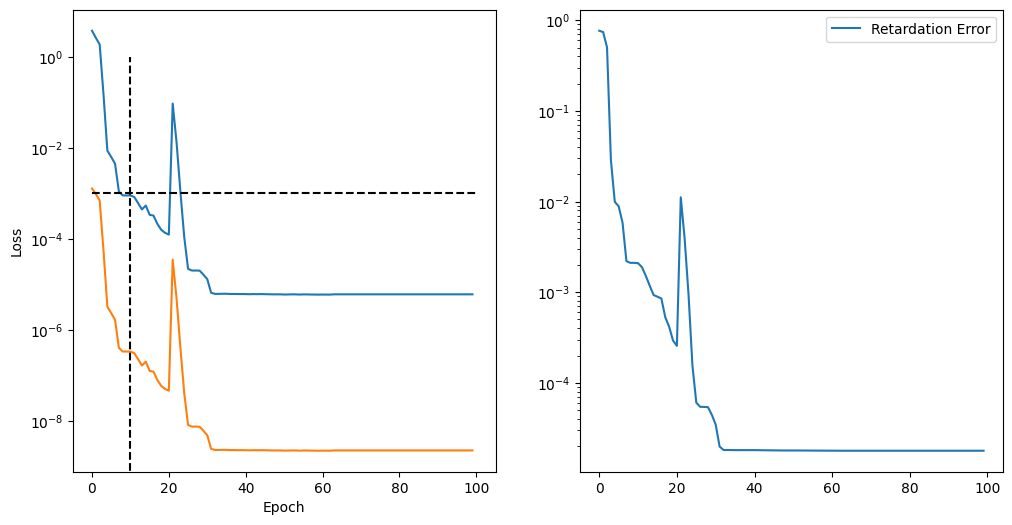

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
# ax.semilogy(loss_mse, label="MSE Loss")
# ax.semilogy(loss_phys, label="Physical Loss")
ax1.semilogy(file_df["loss"], label="Total Loss")
ax1.semilogy(file_df["MSE(c_train_pred, c_train)"], label="MSE")
ax1.vlines(10, 0, 1, color="k", linestyle="--")  # just a random marker
ax1.hlines(1e-3, 0, len(loss), color="k", linestyle="--")  # just a random marker
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.semilogy(file_df["MSE(ret_pred, ret_analytical)"], label="Retardation Error")
# ax2.semilogy(analytical_ret, label=analytical_retardation_type.capitalize())
ax2.legend()
plt.show()

In [11]:
ret_df = file_df.copy()
ret_df["ret"] = ret_df["ret_path"].apply(lambda p: np.load(p).ravel())
ret_df = ret_df.explode("ret").reset_index(drop=True)
ret_df["u"] = np.tile(np.arange(0, 100), len(file_df))
ret_df["ret"] = ret_df["ret"].astype(np.float64)

In [12]:
ret_df

,loss,epoch,ret_path,c_train_pred_path,"MSE(c_train_pred, c_train)","MSE(ret_pred, ret_analytical)",ret,u
0,3.687286,1,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,1.277205e-03,0.768369,2.923158,0
1,3.687286,1,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,1.277205e-03,0.768369,2.923547,1
2,3.687286,1,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,1.277205e-03,0.768369,2.923934,2
3,3.687286,1,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,1.277205e-03,0.768369,2.924320,3
4,3.687286,1,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,1.277205e-03,0.768369,2.924704,4
...,...,...,...,...,...,...,...,...
9995,0.000006,100,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,2.301055e-09,0.000018,2.090709,95
9996,0.000006,100,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,2.301055e-09,0.000018,2.080153,96
9997,0.000006,100,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,2.301055e-09,0.000018,2.069775,97
9998,0.000006,100,../data_out/langmuir/default_finn/predicted_re...,../data_out/langmuir/default_finn/predicted_co...,2.301055e-09,0.000018,2.059573,98


In [13]:
ret_df["loss_split"] = ["left" if loss < 1e-2 else "right" for loss in ret_df["loss"]]

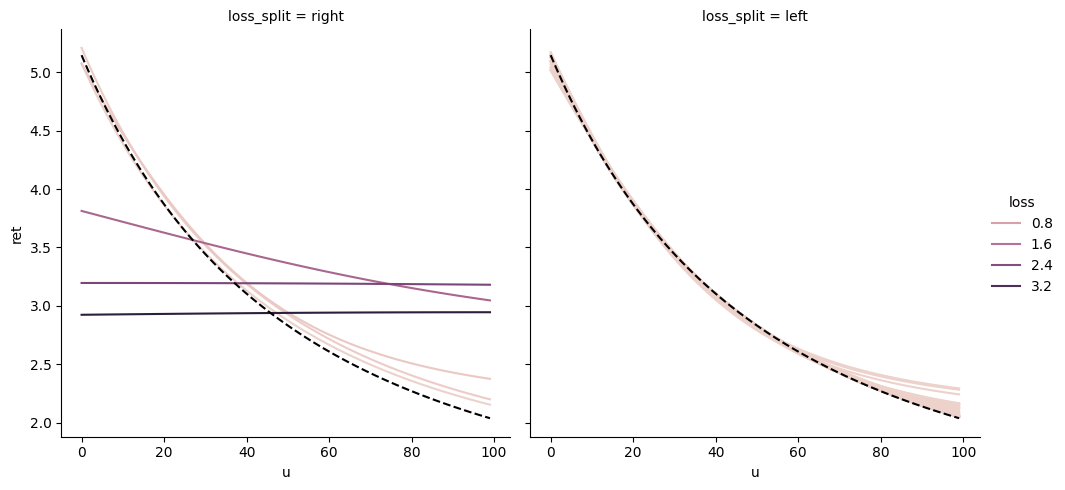

In [14]:
g = sns.relplot(
    data=ret_df,
    kind="line",
    x="u",
    y="ret",
    hue="loss",
    col="loss_split",
)

for ax in g.axes.flat:
    ax.plot(analytical_ret, "k--")
    if analytical_retardation_type == "freundlich":
        ax.set_ylim(3, 5)
plt.show()

# Concentration Field

In [21]:
c_full = np.load(finn_dir / "c_full.npy")
c_full_predictions = np.load(finn_dir / "c_full_predictions.npy")
assert c_full.shape == c_full_predictions.shape
print(c_full.shape)

(2001, 2, 26, 1)


In [22]:
print(np.abs(c_full - c_full_predictions).max())

0.000991106


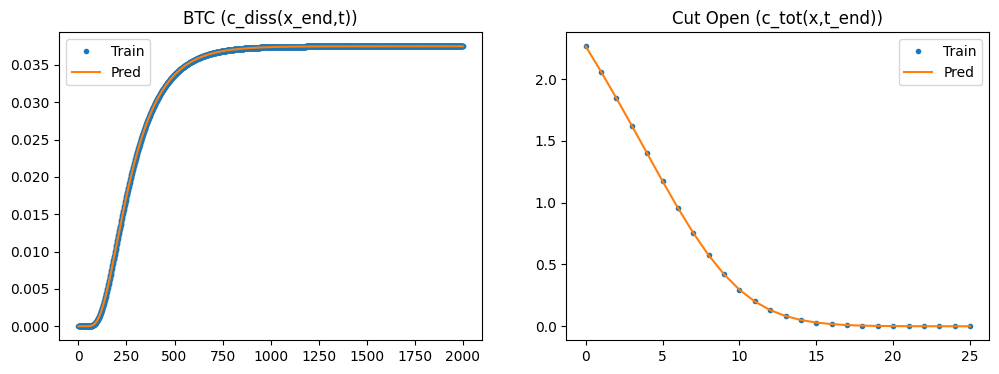

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

t_end = 52

axs[0].set_title("BTC (c_diss(x_end,t))")
axs[0].plot(c_full[:, 0, -1, 0], ".", label="Train")
axs[0].plot(c_full_predictions[:, 0, -1, 0], "-", label="Pred")
axs[0].legend()

axs[1].set_title("Cut Open (c_tot(x,t_end))")
axs[1].plot(c_full[t_end, 1, :, 0], ".", label="Train")
axs[1].plot(c_full_predictions[t_end, 1, :, 0], "-", label="Pred")
axs[1].legend()

plt.show()

In [ ]:
# TODO: Nx=30 vielleicht wegen CFL Bedingung
